# Imports

In [1]:
import os
import json
import pickle
import tinyllm
import dataclasses
from torch import nn
from tqdm import tqdm
from collections import Counter
from datasets import load_dataset, load_from_disk

dataset_path = "datasets/wikipedia"
model_path = "models/tinyllm"

# Dataset

### Download the dataset

In [2]:
# os.makedirs(dataset_path, exist_ok=True)
# dataset = load_dataset("wikimedia/wikipedia", "20231101.en")
# dataset.save_to_disk(dataset_path)

### Load the dataset from disk

In [3]:
dataset = load_from_disk(dataset_path)["train"]
print(f"Length of dataset: {len(dataset):,}")
print(f"Doc Keys: {dataset[0].keys()}")
print(f"Doc Text: {dataset[0]['text'][:100]}")

Loading dataset from disk:   0%|          | 0/41 [00:00<?, ?it/s]

Length of dataset: 6,407,814
Doc Keys: dict_keys(['id', 'url', 'title', 'text'])
Doc Text: Anarchism is a political philosophy and movement that is skeptical of all justifications for authori


# Tokenization

### Train a bpe tokenizer

In [4]:
# chunk_size = 20_000
# word_counts = Counter()
# for i in tqdm(range(0, len(dataset), chunk_size)):
#     chunk = dataset[i:i + chunk_size]
#     word_counts += tinyllm.count_words_in_documents(chunk["text"], processes=32)
# with open(f"{dataset_path}/word_counts.pkl", "wb") as f:
#     pickle.dump(word_counts, f)
# word_counts_str = {bytes(word).decode("utf-8"): count for word, count in word_counts.items()}
# with open(f"{dataset_path}/word_counts.json", "w") as f:
#     json.dump(word_counts_str, f)
# with open(f"{dataset_path}/word_counts.pkl", "rb") as f:
#     word_counts = pickle.load(f)
# with open(f"{dataset_path}/word_counts.json", "r") as f:
#     word_counts_str = json.load(f)
# vocab_size = 2**8 + 500 # 756 is the default vocab size in tinyllm
# text_encoder = tinyllm.TextEncoder()
# text_encoder.train(word_counts, vocab_size=vocab_size, processes=32)
# text_encoder.save(model_path)

### Load and validate the tokenizer

In [5]:
tokenizer = tinyllm.TextEncoder.load(model_path)
assert tokenizer.decode(tokenizer.encode("Hello universe, there is a lot to learn from you")) == "Hello universe, there is a lot to learn from you", "Tokenizer is not working correctly"

### Tokenize the dataset in shards

In [6]:
# !rm -rf {dataset_path}/shards
# shard_size = 50_000_000
# nprocs = 32
# total_tokens = tinyllm.tokenize_and_write_shards(
#     ds=dataset,
#     shard_size=shard_size,
#     nprocs=nprocs,
#     shards_dir=f"{dataset_path}/shards",
#     model_path=model_path,
# )
# total_train_tokens = total_tokens - shard_size # first shard is for validation
# print(f"Total tokens: {total_train_tokens:,}")

# Train the model

In [7]:
model_params = tinyllm.ModelParams(vocab_size=len(tokenizer.vocab))
print(f"Model params: {dataclasses.asdict(model_params)}")
model = tinyllm.TinyLLM(model_params)
model = model.to(model_params.device)
print(f"Number of parameters: {model._num_parameters():,}")

learning_rate = 3e-3
batch_size = 8
total_train_tokens = 226_052_077
optimizer = tinyllm.configure_adamw_optimizer(model, weight_decay=1e-2, learning_rate=learning_rate, betas=(0.9, 0.95), eps=1e-8, device_type=model_params.device)
training_dataset = tinyllm.TinyLLMDataset(shards_path=f"{dataset_path}/shards", T=model_params.context_length, split='train', total_tokens=total_train_tokens)
training_dataloader = tinyllm.DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
loss_fn = nn.CrossEntropyLoss()
train_params = tinyllm.TrainerParams(model=model, train_data=training_dataloader, optimizer=optimizer, gpu_id=0, save_every=500, loss_fn=loss_fn, model_path=model_path)
trainer = tinyllm.Trainer(train_params)
model = trainer.train(steps=15000)

Model params: {'context_length': 512, 'vocab_size': 757, 'num_blocks': 12, 'num_heads': 12, 'd_model': 768, 'head_dim': 64, 'dropout_rate': 0.1, 'num_of_hidden_units': 3072, 'device': 'cuda'}
Number of parameters: 86,031,349
found 5 shards for split train
[GPU0] | Batchsize: 8 | Steps: 55,081
Step 8/55081 | Loss: 6.813 | Norm: 0.222 | LR: 3.3333e-05 | Tokens/s: 125062
Step 16/55081 | Loss: 6.643 | Norm: 0.305 | LR: 6.6667e-05 | Tokens/s: 150173
Step 24/55081 | Loss: 6.329 | Norm: 0.307 | LR: 1.0000e-04 | Tokens/s: 150490
Step 32/55081 | Loss: 6.130 | Norm: 0.219 | LR: 1.3333e-04 | Tokens/s: 151079
Step 40/55081 | Loss: 5.904 | Norm: 0.402 | LR: 1.6667e-04 | Tokens/s: 148949
Step 48/55081 | Loss: 5.827 | Norm: 0.280 | LR: 2.0000e-04 | Tokens/s: 149014
Step 56/55081 | Loss: 5.687 | Norm: 0.234 | LR: 2.3333e-04 | Tokens/s: 149323
Step 64/55081 | Loss: 5.579 | Norm: 0.156 | LR: 2.6667e-04 | Tokens/s: 149059
Step 72/55081 | Loss: 5.547 | Norm: 0.204 | LR: 3.0000e-04 | Tokens/s: 150076
Step 

# Evaluation
- Plot the loss curve
- Generate some samples
- Calculate the Perplexity using the validation set

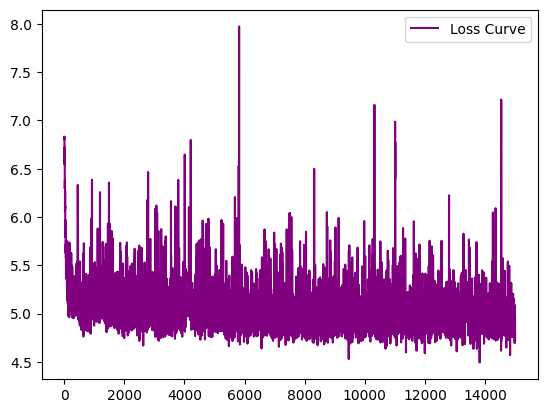

In [8]:
tinyllm.plot_loss_curve(trainer.train_steps, trainer.train_losses, None)

In [9]:
# generate text
import torch
prompt = "The moon is"
prompt_ids = tokenizer.encode(prompt)
prompt_ids = torch.tensor(prompt_ids, device=model_params.device).unsqueeze(0)
trainer.model.eval()
with torch.no_grad():
    generated_ids = trainer.model.generate(prompt_ids, 100)
    string = tokenizer.decode(generated_ids[0].tolist())
print(string)

The moon isar hioiurowat ,wEthla evtimingde2o  St Bkes  in e ilerr, exid P bandool Ath bac  s hury d y  on
 f .a erine c  ovandandokus V Hkest2oc fenamcw he onaeragench th9or
